<a href="https://colab.research.google.com/github/MrSingh6435/HandwrittenDigitGAN_MNISTGAN/blob/main/HandwrittenDigitGAN_MNISTGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Reshape, Flatten, Dropout

# Load and preprocess MNIST data
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
X_train = np.expand_dims(X_train, axis=-1)

# Define generator and discriminator architectures
def build_generator(noise_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=noise_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(28*28*1, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model

def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Build discriminator and generator
noise_dim = 100
discriminator = build_discriminator((28, 28, 1))
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

generator = build_generator(noise_dim)

# Build GAN
gan_input = tf.keras.Input(shape=(noise_dim,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam())

# Function to train GAN
def train_gan(generator, discriminator, gan, data, epochs, batch_size, noise_dim):
    half_batch = batch_size // 2
    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_imgs = data[idx]
        noise = np.random.normal(0, 1, (half_batch, noise_dim))
        fake_imgs = generator.predict(noise)
        d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        valid_y = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_y)

        # Print progress and save generated images
        if epoch % 1000 == 0:
            print(f"Epoch {epoch} - D loss: {d_loss[0]} - G loss: {g_loss}")
            save_generated_images(epoch, generator, noise_dim)

    # Save the models after training
    generator.save('generator_model.h5')
    discriminator.save('discriminator_model.h5')
    gan.save('gan_model.h5')

# Function to save generated images
def save_generated_images(epoch, generator, noise_dim, num_examples=25, figsize=(5, 5)):
    noise = np.random.normal(0, 1, (num_examples, noise_dim))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]

    fig, axs = plt.subplots(5, 5, figsize=figsize, sharey=True, sharex=True)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(generated_images[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch}.png')
    plt.close()

# Usage
train_gan(generator, discriminator, gan, X_train, epochs=10000, batch_size=64, noise_dim=noise_dim)


1/1 [==============================] - 0s 70ms/step
Epoch 0 - D loss: 0.9407112300395966 - G loss: 0.7494251728057861
1/1 [==============================] - 0s 15ms/step
Epoch 1000 - D loss: 0.05532507839961909 - G loss: 7.119769096374512
1/1 [==============================] - 0s 16ms/step
Epoch 2000 - D loss: 0.11590099414661381 - G loss: 11.652637481689453
1/1 [==============================] - 0s 16ms/step
Epoch 3000 - D loss: 0.24382616579532623 - G loss: 10.468320846557617
1/1 [==============================] - 0s 15ms/step
Epoch 4000 - D loss: 0.41394053399562836 - G loss: 5.194380283355713
1/1 [==============================] - 0s 17ms/step
Epoch 5000 - D loss: 0.691100113093853 - G loss: 3.770354747772217
1/1 [==============================] - 0s 16ms/step
Epoch 6000 - D loss: 1.9426703974604607 - G loss: 8.871679306030273
1/1 [==============================] - 0s 18ms/step
Epoch 7000 - D loss: 0.7886846363544464 - G loss: 7.194371223449707
1/1 [==============================] 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

In [ ]:
generator = load_model('generator_model.h5')

In [ ]:
def generate_images(generator, noise_dim, num_examples=25, figsize=(5, 5)):
    noise = np.random.normal(0, 1, (num_examples, noise_dim))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]

    fig, axs = plt.subplots(5, 5, figsize=figsize, sharey=True, sharex=True)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(generated_images[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 76ms/step


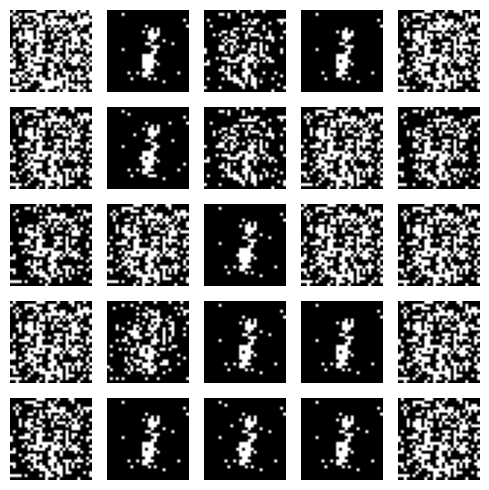

In [ ]:
# Example usage to generate images
generate_images(generator, noise_dim=100, num_examples=25)